In [28]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

import scipy
import anndata
import random
import pandas as pd
import warnings
import matplotlib.patches as mpatches
import scanpy as sc

import csv
import concurrent
import ast
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale

from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

from scipy.stats import zscore
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist, squareform

import seaborn as sns

def nd(arr):
    return np.asarray(arr).reshape(-1)

# Violin plot functions

def vplot(y, ax):
    parts = ax.violinplot(
        y, showmeans=False, showmedians=False,
        showextrema=False)

    mean = y.mean()
    ax.scatter(1, mean, zorder=10, color="white")
    
    x = np.random.normal(1, 0.04, size=len(y))
    ax.scatter(x, y, color="k", s=1)
    
    for pc in parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
    
    ax.set_xticks([1])
    ax.set_xticklabels([""])
    return ax

def vplot_de(x, unique, specific_gene, specific_cluster, ax):
    unique = unique.astype(str)
    labels = unique
    lidx = np.arange(1, len(labels)+1)  # the label locations
    midx = np.where(unique==specific_cluster)[0][0]
    
    
    parts = ax.violinplot(x, showmedians=False, showextrema=False)
    for pcidx, pc in enumerate(parts['bodies']):
        pc.set_facecolor('grey')
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        if pcidx == midx:
            pc.set_facecolor('#D43F3A')
            
    mean = [np.mean(i) for i in x]
    ax.scatter(lidx, mean, marker='o', color='white', s=30, zorder=3)
    
    ax.set_ylabel("$log(CPM + 1)$".format(specific_gene))
    ax.set_xticks(lidx)
    ax.set_xticklabels(labels, rotation=0, ha="center")
    ax.set_title("{} gene in cluster {}".format(specific_gene, specific_cluster))
    
    return ax

warnings.filterwarnings('ignore')

fsize=20
plt.rcParams.update({'font.size': fsize})

plt.rcParams["figure.dpi"] = 300



In [29]:
# Path to count matrices (transcript-level)
counts_dir = "splitseq_out_supplement/quant_unfiltered/"
matrix_path=counts_dir+"../quant_unfiltered/matrix.abundance.mtx" # matrix_path=counts_dir+"matrix.abundance.mtx" # 
#matrix_path=counts_dir+"matrix.abundance.mtx"
transcripts_path=counts_dir+"transcripts.txt"
barcodes_path=counts_dir+"../counts_unfiltered_modified/cells_x_tcc.barcodes.txt"
# Path to count matrices (gene-level)
counts_dir_gene = "splitseq_out_supplement/counts_unfiltered_modified/"
matrix_path_gene=counts_dir_gene+"cells_x_genes.total.mtx"
matrix_path_gene_M=counts_dir_gene+"cells_x_genes.mature.mtx"
matrix_path_gene_N=counts_dir_gene+"cells_x_genes.nascent.mtx"
matrix_path_gene_A=counts_dir_gene+"cells_x_genes.ambiguous.mtx"
genes_path=counts_dir_gene+"cells_x_genes.genes.txt"
barcodes_path_gene=counts_dir_gene+"cells_x_genes.barcodes.txt"
# Path to annotation file
annotation_file="Smart3.PBMC.annotated.txt"

In [30]:
# Load transcript-level matrix

with open(transcripts_path, 'r') as f:
    transcripts = [line.strip().split()[0] for line in f]

with open(barcodes_path, 'r') as f:
    barcodes = [line.strip() for line in f]

with open(counts_dir_gene+"cells_x_genes.barcodes.prefix.txt", 'r') as f:
    barcodes_prefix = [line.strip() for line in f]

data = anndata.AnnData(scipy.io.mmread(matrix_path).tocsr()).T  # float32 matrix
data = data.T

In [31]:
# Load gene-level (total N+A+M) matrix

with open(genes_path, 'r') as f:
    genes = [line.strip().split()[0] for line in f]

with open(barcodes_path_gene, 'r') as f:
    barcodes_gene = [line.strip() for line in f]

data_gene = anndata.AnnData(scipy.io.mmread(matrix_path_gene).tocsr()).T  # float32 matrix
data_gene = data_gene.T

# Load gene-level M matrix

data_gene_M = anndata.AnnData(scipy.io.mmread(matrix_path_gene_M).tocsr()).T  # float32 matrix
data_gene_M = data_gene_M.T


# Load gene-level A matrix

data_gene_A = anndata.AnnData(scipy.io.mmread(matrix_path_gene_A).tocsr()).T  # float32 matrix
data_gene_A = data_gene_A.T


# Load gene-level N matrix

data_gene_N = anndata.AnnData(scipy.io.mmread(matrix_path_gene_N).tocsr()).T  # float32 matrix
data_gene_N = data_gene_N.T


In [32]:
# Just make some copies so it's easy to revisit the raw matrices later
xx = data.copy()
data = xx.copy()
xx_gene = data_gene.copy()
data_gene = xx_gene.copy()
xx_gene_A = data_gene_A.copy()
data_gene_A = xx_gene_A.copy()
xx_gene_M = data_gene_M.copy()
data_gene_M = xx_gene_M.copy()
xx_gene_N = data_gene_N.copy()
data_gene_N = xx_gene_N.copy()

In [33]:
# Load/reload the raw matrices
data = xx.copy()
data_gene = xx_gene.copy()
data_gene_A = xx_gene_A.copy()
data_gene_M = xx_gene_M.copy()
data_gene_N = xx_gene_N.copy()

In [34]:
data.obs_names = barcodes
# data.var_names = transcripts #
# data.var['transcript_id'] = transcripts #
# data.var['transcript_name'] = transcripts #

data_gene.obs_names = barcodes_gene
data_gene.var_names = genes
data_gene.var['gene_id'] = genes
data_gene.var['gene_name'] = genes

data_gene_A.obs_names = barcodes_gene
data_gene_A.var_names = genes
data_gene_A.var['gene_id'] = genes
data_gene_A.var['gene_name'] = genes

data_gene_M.obs_names = barcodes_gene
data_gene_M.var_names = genes
data_gene_M.var['gene_id'] = genes
data_gene_M.var['gene_name'] = genes

data_gene_N.obs_names = barcodes_gene
data_gene_N.var_names = genes
data_gene_N.var['gene_id'] = genes
data_gene_N.var['gene_name'] = genes

# Barcode mapping and filtering

mapping_df = pd.read_csv(annotation_file, sep='\t')
mapping = pd.Series(mapping_df.clusterName.values, index=mapping_df.cellID).to_dict()

data.obs['id'] = data.obs.index.map(mapping)
data_gene.obs['id'] = data_gene.obs.index.map(mapping)
data_gene_A.obs['id'] = data_gene_A.obs.index.map(mapping)
data_gene_M.obs['id'] = data_gene_M.obs.index.map(mapping)
data_gene_N.obs['id'] = data_gene_N.obs.index.map(mapping)

data.obs['id'] = barcodes_prefix
data_gene.obs['id'] = barcodes_prefix

In [35]:
data.obs

,id
AACAACCAAATGTTGCACTCGTAA,AAAAAAAAAAAAAAAA
AACAACCAAGATCGCAACTCGTAA,AAAAAAAAAAAAAAAA
AACAACCATATCAGCAATAAGCTC,AAAAAAAAAAAAAAAA
AACGCTTAAGCAGGAAATTCATGG,AAAAAAAAAAAAAAAA
AACGCTTACAATGGAAAAACGATA,AAAAAAAAAAAAAAAA
...,...
TGGCTTCAATCATTCCACTCGTAA,AAAAAAAAAAAAAACG
TGGTGGTAAACTCACCATCCGCGA,AAAAAAAAAAAAAACG
TGGTGGTAAAGGTACACGTTCGAG,AAAAAAAAAAAAAACG
TTCACGCAAACTCACCTCTATTAC,AAAAAAAAAAAAAACG


In [36]:
data.obs["cell_counts"] = data.X.sum(axis=1)
data.var["transcript_counts"] = nd(data.X.sum(axis=0))
data.obs["n_transcripts"] = nd((data.X>0).sum(axis=1))
data.var["n_cells"] = nd((data.X>0).sum(axis=0))
# data.var_names = list(data.var.transcript_name) #
# data.var_names_make_unique() #

data_gene.obs["cell_counts"] = data_gene.X.sum(axis=1)
data_gene.var["gene_counts"] = nd(data_gene.X.sum(axis=0))
data_gene.obs["n_genes"] = nd((data_gene.X>0).sum(axis=1))
data_gene.var["n_cells"] = nd((data_gene.X>0).sum(axis=0))
data_gene.var_names = list(data_gene.var.gene_name)
data_gene.var_names_make_unique()


data_gene_A.obs["cell_counts"] = data_gene_A.X.sum(axis=1)
data_gene_A.var["gene_counts"] = nd(data_gene_A.X.sum(axis=0))
data_gene_A.obs["n_genes"] = nd((data_gene_A.X>0).sum(axis=1))
data_gene_A.var["n_cells"] = nd((data_gene_A.X>0).sum(axis=0))
data_gene_A.var_names = list(data_gene_A.var.gene_name)
data_gene_A.var_names_make_unique()

data_gene_M.obs["cell_counts"] = data_gene_M.X.sum(axis=1)
data_gene_M.var["gene_counts"] = nd(data_gene_M.X.sum(axis=0))
data_gene_M.obs["n_genes"] = nd((data_gene_M.X>0).sum(axis=1))
data_gene_M.var["n_cells"] = nd((data_gene_M.X>0).sum(axis=0))
data_gene_M.var_names = list(data_gene_M.var.gene_name)
data_gene_M.var_names_make_unique()

data_gene_N.obs["cell_counts"] = data_gene_N.X.sum(axis=1)
data_gene_N.var["gene_counts"] = nd(data_gene_N.X.sum(axis=0))
data_gene_N.obs["n_genes"] = nd((data_gene_N.X>0).sum(axis=1))
data_gene_N.var["n_cells"] = nd((data_gene_N.X>0).sum(axis=0))
data_gene_N.var_names = list(data_gene_N.var.gene_name)
data_gene_N.var_names_make_unique()

print(data)

AnnData object with n_obs × n_vars = 839 × 158430
    obs: 'id', 'cell_counts', 'n_transcripts'
    var: 'transcript_counts', 'n_cells'


In [41]:
data.var['transcript_id'] = transcripts

In [234]:
transcript_ids = [
    "ENSMUSG00000067274.11",
    "ENSMUST00000086519.12",
    "ENSMUST00000156359.2",
    "ENSMUST00000152976.2",
    "ENSMUST00000155584.2"
]

# Subset the data object to include only the desired transcripts
subset_data = data.obs[data.obs.index.isin(filtered_cells.obs.index)].copy()
subset_data = data[:, data.var['transcript_id'].isin(transcript_ids)]
subset_data = data[:, data.var['transcript_id'].isin(transcript_ids)]

# Calculate total counts per cell for the selected transcripts
total_counts = subset_data.X.sum(axis=1)

# Filter out cells with zero total counts (or rather, cells with fewer than X umi counts)
non_zero_cells = total_counts > 0
filtered_data = subset_data[non_zero_cells]
filtered_total_counts = total_counts[non_zero_cells]
filtered_total_counts = total_counts[non_zero_cells].reshape(-1, 1)  # Reshape for broadcasting

# Calculate the proportion of each transcript for each cell
proportions = filtered_data.X / (filtered_total_counts)

# Create a DataFrame to display the proportions
proportions_df = pd.DataFrame(
    np.array(proportions), 
    columns=filtered_data.var['transcript_id'], 
    index=filtered_data.obs_names
)

# Display the proportions as percentages
proportions_percentage_df = proportions_df * 100

proportions_percentage_df


transcript_id,ENSMUST00000086519.12,ENSMUST00000152976.2,ENSMUST00000155584.2,ENSMUST00000156359.2,ENSMUSG00000067274.11
AACAACCAAATGTTGCACTCGTAA,100.000000,0.0,0.0,0.000000,0.000000
AACAACCAAGATCGCAACTCGTAA,33.333336,0.0,0.0,33.333336,33.333336
AACAACCATATCAGCAATAAGCTC,100.000000,0.0,0.0,0.000000,0.000000
AACGCTTAAGCAGGAAATTCATGG,100.000000,0.0,0.0,0.000000,0.000000
AACGCTTACAATGGAAAAACGATA,100.000000,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...
TGGAACAATGGAACAAATCCGCGA,100.000000,0.0,0.0,0.000000,0.000000
TGGTGGTAAACTCACCATCCGCGA,0.000000,0.0,0.0,0.000000,100.000000
TGGTGGTAAAGGTACACGTTCGAG,100.000000,0.0,0.0,0.000000,0.000000
TTCACGCAAACTCACCTCTATTAC,50.000000,0.0,0.0,0.000000,50.000000


In [264]:
transcript_ids

['ENSMUSG00000067274.11',
 'ENSMUST00000086519.12',
 'ENSMUST00000156359.2',
 'ENSMUST00000152976.2',
 'ENSMUST00000155584.2']

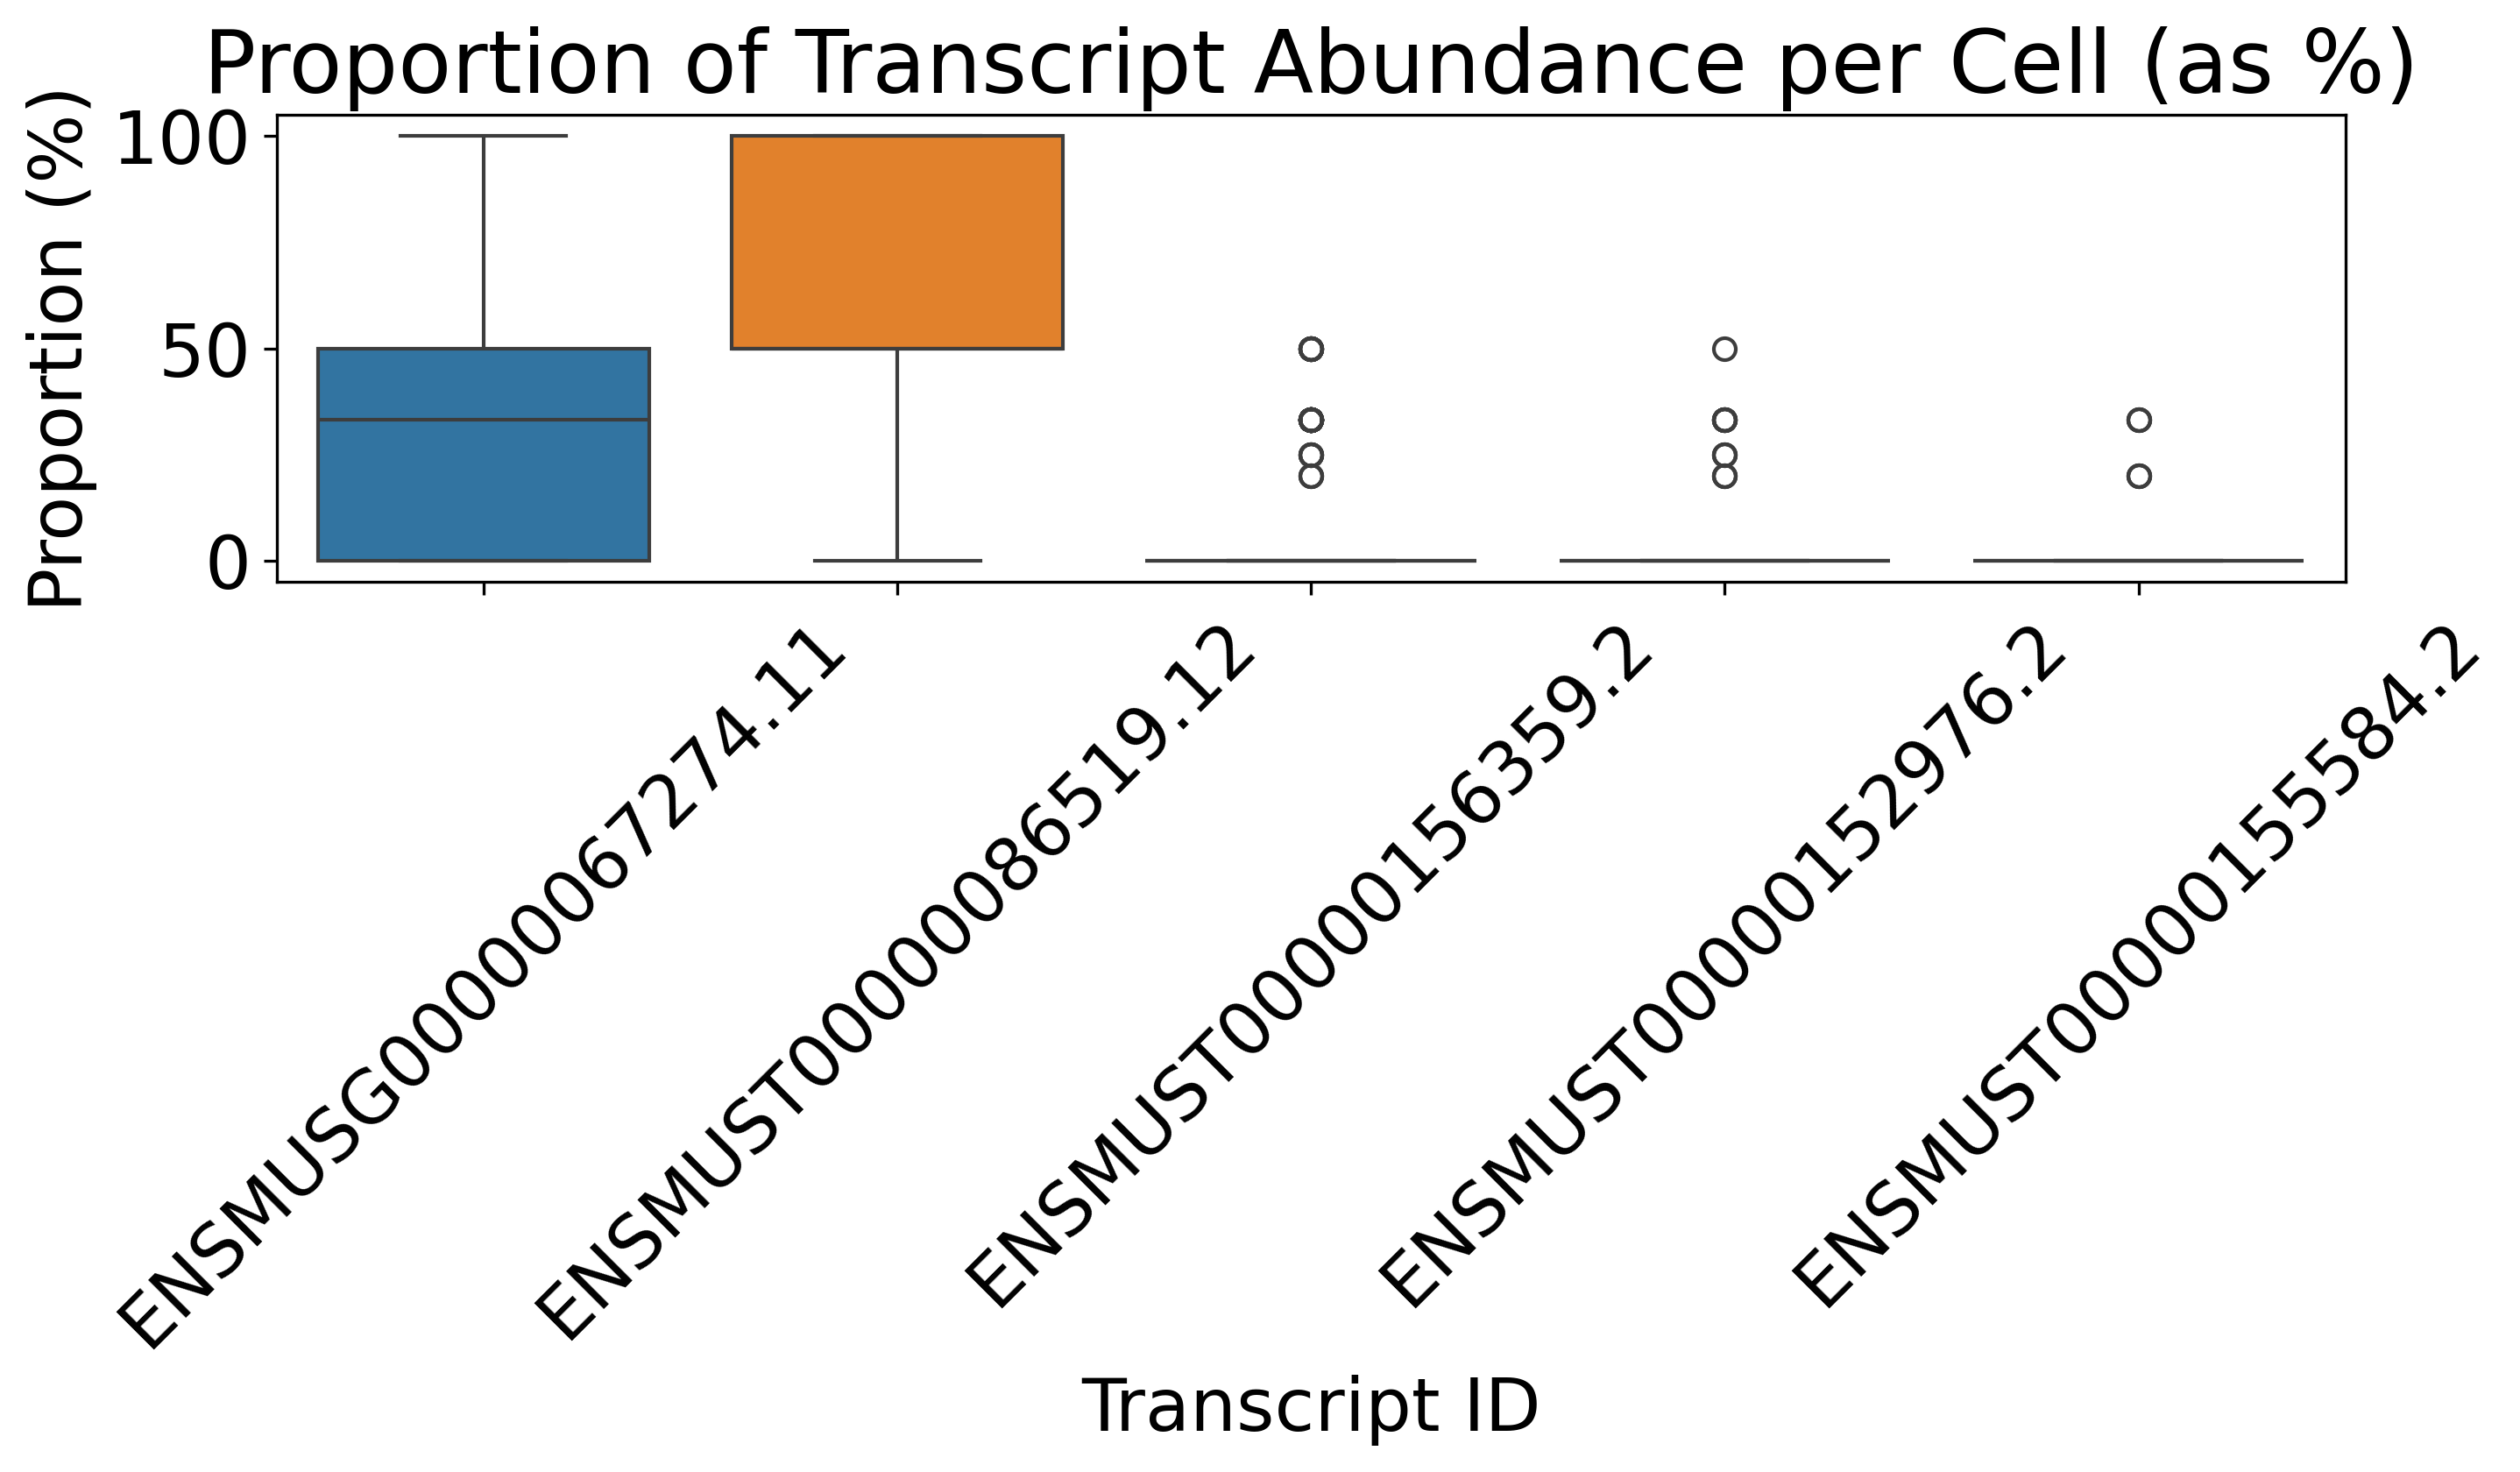

In [261]:
import seaborn as sns

# Make sure seaborn is installed; if not, run: pip install seaborn

# Create a violin plot for each transcript in your dataframe
plt.figure(figsize=(10, 6))
sns.boxplot(data=proportions_percentage_df[transcript_ids])
plt.title('Proportion of Transcript Abundance per Cell (as %)')
plt.xlabel('Transcript ID')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [247]:
# Transcript IDs of interest
transcript_ids = [
    "ENSMUSG00000067274.11", 
    "ENSMUST00000086519.12", 
    "ENSMUST00000156359.2", 
    "ENSMUST00000152976.2", 
    "ENSMUST00000155584.2"
]

# Directory where files are stored
dir_path = './splitseq_out_supplement/quant_unfiltered/'

# Prepare a DataFrame to store the standard deviations for each transcript
std_dev_df = pd.DataFrame(index=range(1, 840), columns=transcript_ids)

# Iterate through each {n} from 1 to 839
for n in range(1, 840):
    # Create list of file paths
    file_paths = [f'{dir_path}abundance_{n}.tsv'] + [f'{dir_path}bs_abundance_{n}_{i}.tsv' for i in range(10)]

    # Create a list to store the proportion data for the 10 files
    proportions = {transcript: [] for transcript in transcript_ids}

    zero = False

    # Process each of the 10 files
    for file_path in file_paths:
        # Load the file into a pandas DataFrame
        df = pd.read_csv(file_path, sep='\t')

        # Filter rows based on the transcript IDs
        filtered_df = df[df.iloc[:, 0].isin(transcript_ids)]

        # Get the abundance values (assumed to be in the 4th column, index 3)
        abundance_values = filtered_df.iloc[:, 3].values

        # Calculate total abundance for the filtered transcripts
        total_abundance = abundance_values.sum()

        if total_abundance == 0:
            zero = True

        # Calculate the proportion for each transcript (as percentages)
        proportion_values = (abundance_values / total_abundance) * 100

        # Add the proportion values to the list for each transcript
        for transcript, proportion in zip(filtered_df.iloc[:, 0].values, proportion_values):
            proportions[transcript].append(proportion)

    if zero:
        next

    # Calculate the standard deviation for each transcript across the 10 files
    for transcript in transcript_ids:
        if proportions[transcript]:
            std_dev_df.at[n, transcript] = pd.Series(proportions[transcript]).std()



In [252]:
std_dev_df = std_dev_df.dropna()

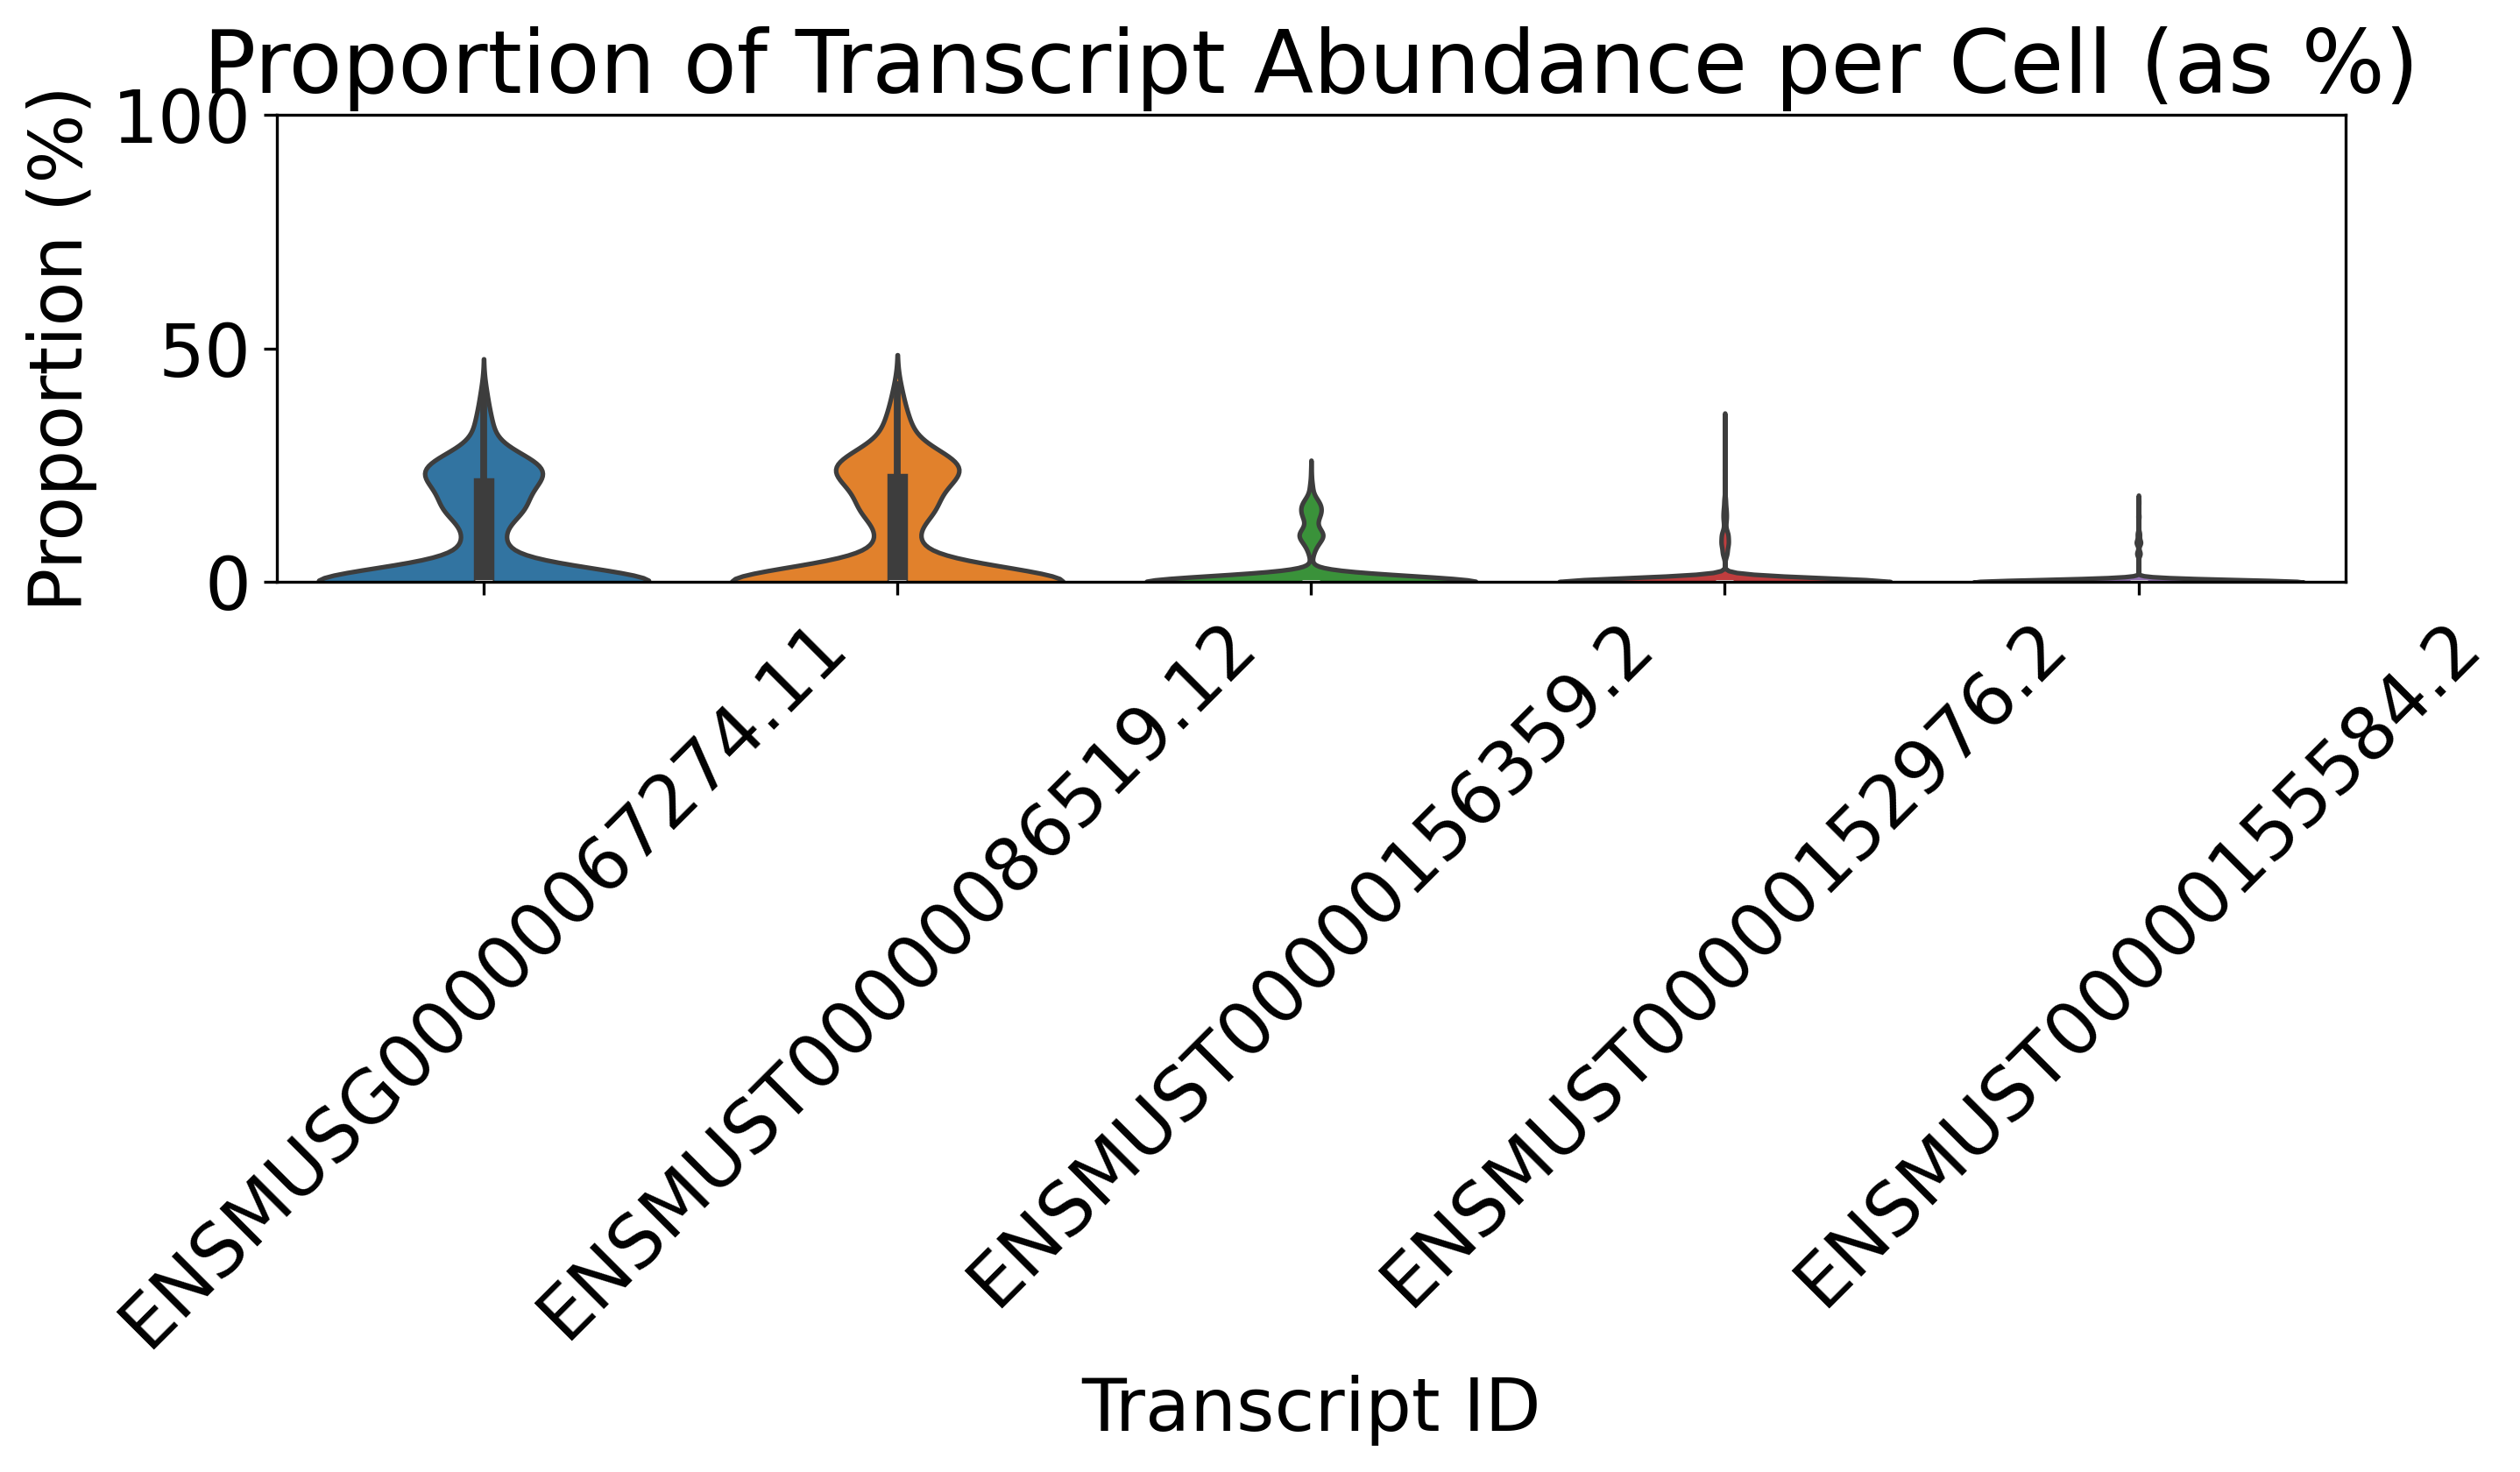

In [256]:
import seaborn as sns

# Make sure seaborn is installed; if not, run: pip install seaborn

# Create a violin plot for each transcript in your dataframe
plt.figure(figsize=(10, 6))
sns.violinplot(data=std_dev_df)
plt.title('Proportion of Transcript Abundance per Cell (as %)')
plt.xlabel('Transcript ID')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.ylim(0,100)
plt.tight_layout()
plt.show()


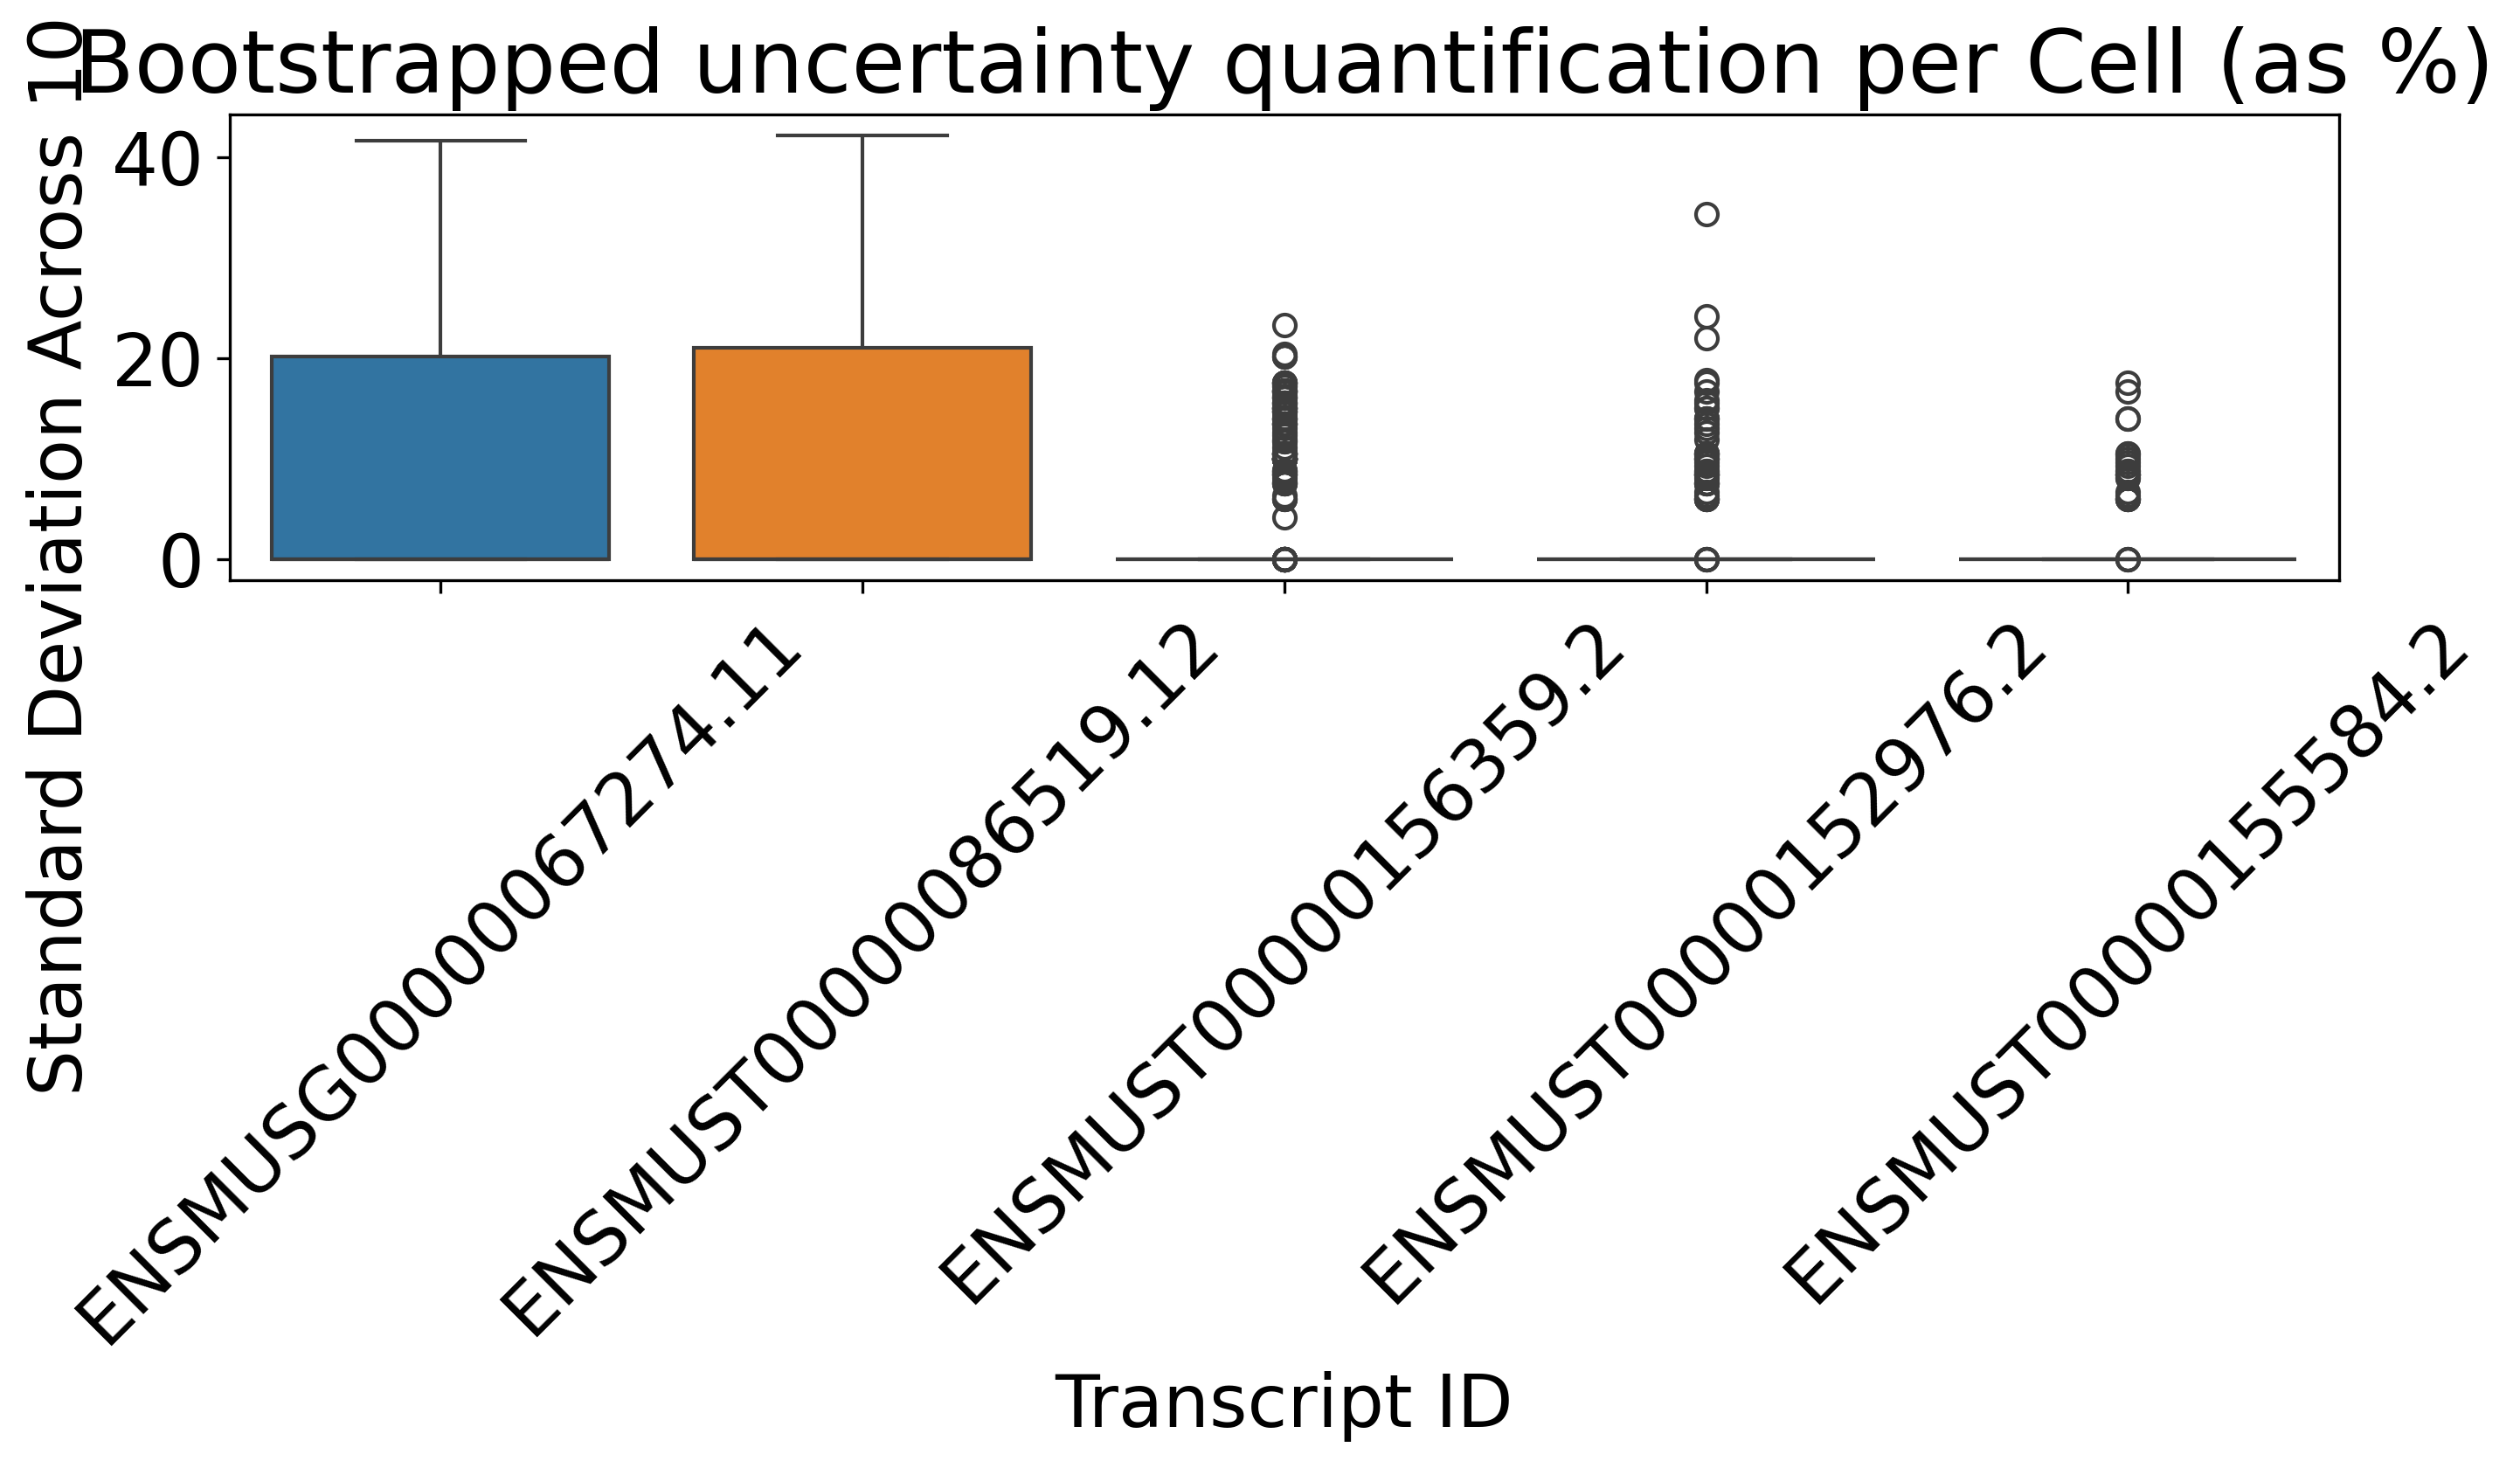

In [267]:
import seaborn as sns

# Make sure seaborn is installed; if not, run: pip install seaborn

# Create a violin plot for each transcript in your dataframe
plt.figure(figsize=(10, 6))
sns.boxplot(data=std_dev_df[transcript_ids])
plt.title('Bootstrapped uncertainty quantification per Cell (as %)')
plt.xlabel('Transcript ID')
plt.ylabel('Standard Deviation Across 10 Bootstraps')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
